In [339]:
import scipy
import scipy.io.wavfile
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot
import matplotlib.path as mplPath
import pylab
import itertools

%matplotlib inline

In [440]:
# Code from last homework to derive peak maps

def stft(x, window_len=4096, window_shift=2048):
    w = scipy.hamming(window_len)
    X = scipy.array([scipy.fft(w*x[i:i+window_len])
        for i in range(0, len(x)-window_len, window_shift)])
    return scipy.absolute(X[:,0:window_len/2])

def findPeaks(X):
    from scipy.ndimage.filters import maximum_filter
    # changed from 20 to 40
    maxima = (X == maximum_filter(X,40))
    peaksArray = zip(np.where(maxima)[0],np.where(maxima)[1])
    return peaksArray

# Plot a list of peaks in the form [(s1, f1), (s2, f2), ...]
def plot_peaks(peak_list):
    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    s_list, f_list = zip(*peak_list)
    matplotlib.pyplot.plot(s_list, f_list, 'bo')
    ymin, ymax = ax.get_ylim()
    matplotlib.pyplot.xlabel('Window index')
    matplotlib.pyplot.ylabel('Transform coefficient')


In [445]:
rate1, data1 = scipy.io.wavfile.read('1.wav')
rate2, data2 = scipy.io.wavfile.read('2.wav')
rate3, data3 = scipy.io.wavfile.read('3.wav')
rate7, data7 = scipy.io.wavfile.read('7.wav')
rate8, data8 = scipy.io.wavfile.read('8.wav')
if (len(data1.shape) > 1):
    data1 = data1[:,0]
if (len(data2.shape) > 1):
    data2 = data2[:,0]
if (len(data3.shape) > 1):
    data3 = data3[:,0]
if (len(data7.shape) > 1):    
    data7 = data7[:,0]
if (len(data8.shape) > 1):
    data8 = data8[:,0]
x1 = data1[0:10*rate1]
x2 = data2[0:10*rate2]
x3 = data3[0:10*rate3]
x7 = data7[0:10*rate7]
x8 = data8[0:10*rate8]
X1 = stft(x1)
X2 = stft(x2)
X3 = stft(x3)
X7 = stft(x7)
X8 = stft(x8)

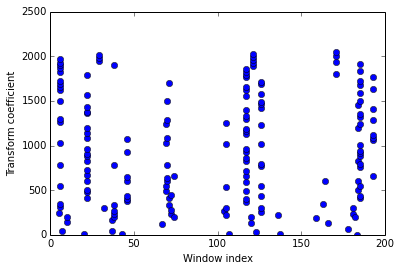

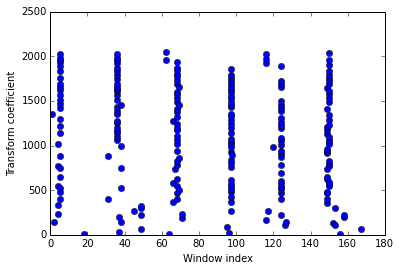

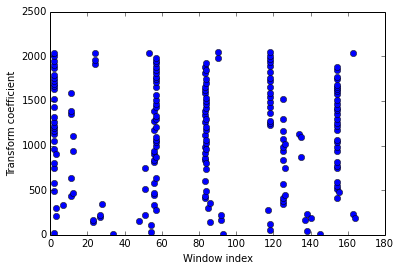

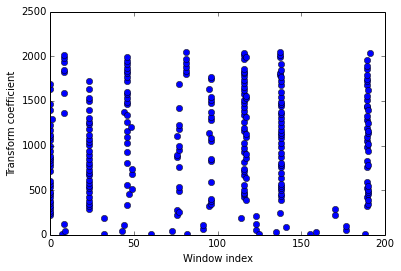

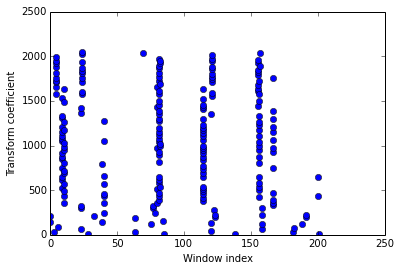

In [446]:
peaksArray1 = findPeaks(X1)
peaksArray2 = findPeaks(X2)
peaksArray3 = findPeaks(X3)
peaksArray7 = findPeaks(X7)
peaksArray8 = findPeaks(X8)
plot_peaks(peaksArray1)
plot_peaks(peaksArray2)
plot_peaks(peaksArray3)
plot_peaks(peaksArray7)
plot_peaks(peaksArray8)


In [403]:
# N: number of points
# f: frequency gap
# t: time gap

def target_zone_peaks(peak_list, n, time_gap, frequency_gap):

    top_peaks = []
    for new_peak in peak_list:
        
        target_zone = []
        top_peaks.append((new_peak, target_zone))
        
        for entry in top_peaks:
            
            peak_time = entry[0][0]
            peak_freq = entry[0][1]
        
            target_zone_x1 = peak_time
            target_zone_x2 = peak_time + time_gap
            #if (peak_freq < (frequency_gap/2)):
            #    target_zone_y1 = 0
            #    target_zone_y2 = frequency_gap
            #else:
            target_zone_y1 = peak_freq - (frequency_gap/2)
            target_zone_y2 = peak_freq + (frequency_gap/2)
            
            target_zone_path = mplPath.Path(np.array([[target_zone_x1, target_zone_y1],
                     [target_zone_x1, target_zone_y2],
                     [target_zone_x2, target_zone_y1],
                     [target_zone_x2, target_zone_y2]]))
            
            if (target_zone_path.contains_point(new_peak)):
                # n is being arbitrarily selected as the first n peaks
                # should this be calulated through euclidean distance?
                if (len(entry[1]) <= n):
                    entry[1].append(new_peak)

    return top_peaks
        

In [404]:
def top_n_peaks(peaks, n):
    print len(peaks[1])
    if (len(peaks[1]) <= n):
        print "no problem here"
    else:
        peaks_dist = scipy.spatial.distance.cdist([peaks[0]], peaks[1], 'euclidean')
        print peaks_dist

In [113]:
top_n_peaks(audio1_target_zone_peaks[0], 20)

21
[[  35.12833614   46.17358552   33.24154028   19.41648784   48.16637832
    29.73213749   20.88061302   25.61249695   37.21558813   41.59326869
    48.27007354   57.55866572   67.0298441    73.38937253   74.67261881
    72.99315036  103.81714695  104.12012294  115.00434774  162.0277754
   182.00274723]]


In [447]:
audio1_target_zone_peaks = target_zone_peaks(peaksArray1, 40, 100, 100)
audio2_target_zone_peaks = target_zone_peaks(peaksArray2, 40, 100, 100)
audio3_target_zone_peaks = target_zone_peaks(peaksArray3, 40, 100, 100)
audio7_target_zone_peaks = target_zone_peaks(peaksArray7, 40, 100, 100)
audio8_target_zone_peaks = target_zone_peaks(peaksArray8, 40, 100, 100)


In [406]:
print audio1_target_zone_peaks[0]

((2, 488), [(5, 523), (6, 455), (6, 469), (22, 466), (22, 482), (22, 504), (39, 484), (69, 486), (74, 500), (86, 519)])


In [82]:
def linear_hash_function(main_peak, new_peak):
    #linear hash function defined by Ori on Piazza:
    #   frequency1 + difference in frequencies + difference in time
    
    freq_diff = new_peak[1] - main_peak[1]
    time_diff = new_peak[0] - main_peak[0]
    hash_value = main_peak[1] + freq_diff + time_diff
    return hash_value

In [240]:
def hash_table(target_zone_peaks):
    hash_table = []
    for zone in target_zone_peaks:
        main_peak = zone[0]
        target_zone = zone[1]
        
        for peak in target_zone:
            hash_value = linear_hash_function(main_peak, peak)
            time1 = main_peak[0]
            
            hash_table.append((time1, hash_value))

    return hash_table

In [449]:
audio1_hash = hash_table(audio1_target_zone_peaks)
audio2_hash = hash_table(audio2_target_zone_peaks)
audio3_hash = hash_table(audio3_target_zone_peaks)
audio7_hash = hash_table(audio7_target_zone_peaks)
audio8_hash = hash_table(audio8_target_zone_peaks)

In [350]:
def match_hash_tables(hash_table_1, hash_table_2):
    match_hash_times = {}
    
    # convert hash tables to numpy arrays
    np_hash_table_1 = np.array(hash_table_1)
    np_hash_table_2 = np.array(hash_table_2)
    
    # take only hash values from each numpy hash table
    hash_values_1 = [hash_grp[1] for hash_grp in np_hash_table_1]
    hash_values_2 = [hash_grp[1] for hash_grp in np_hash_table_2]
    
    #print len(hash_values_1)
    #print len(set(hash_values_1))

    # find common hash values in both numpy hash tables
    hash_value_matches_bool_1 = np.in1d(hash_values_1, hash_values_2)
    hash_value_matches_bool_2 = np.in1d(hash_values_2, hash_values_1)

    # return only elements from each numpy hash table that have a match
    matched_table_1 = np_hash_table_1[hash_value_matches_bool_1]
    matched_table_2 = np_hash_table_2[hash_value_matches_bool_2]
    
    # matching hash values across both hash tables (2a)
    matched_hash_values = [hash_grp[1] for hash_grp in matched_table_1]
    
    #print len(matched_hash_values)
    #print len(set(matched_hash_values))
    
    # finds the time values for matched hashes in hash table 1
    for unique_hash in matched_hash_values:
        match_times_1 = np.where(matched_table_1 == unique_hash)[0]
        match_times_2 = np.where(matched_table_2 == unique_hash)[0]
        match_times_1 = [y_i[0] for y_i in matched_table_1[match_times_1]]
        match_times_2 = [y_i[0] for y_i in matched_table_2[match_times_2]]
        match_hash_times[unique_hash] = [set(match_times_1)]
        match_hash_times[unique_hash].append(set(match_times_2))

    return match_hash_times

In [450]:
audio_matches_1_2 = match_hash_tables(audio1_hash, audio2_hash)
audio_matches_1_3 = match_hash_tables(audio1_hash, audio3_hash)
audio_matches_2_3 = match_hash_tables(audio2_hash, audio3_hash)
audio_matches_dummy = match_hash_tables(audio1_hash, audio1_hash)

In [396]:
def match_times_2d_pairs(audio_matches):
    time_pairs = []
    for key in audio_matches:
        times = audio_matches.get(key)
        audio1_times = list(times[0])
        audio2_times = list(times[1])
        pairs = list(itertools.product(audio1_times, audio2_times))
        time_pairs.append(pairs)
    time_pairs = sum(time_pairs, [])
    return time_pairs

In [451]:
time_pairs_1_2 = match_times_2d_pairs(audio_matches_1_2)
time_pairs_1_3 = match_times_2d_pairs(audio_matches_1_3)
time_pairs_2_3 = match_times_2d_pairs(audio_matches_2_3)
time_pairs_dummy = match_times_2d_pairs(audio_matches_dummy)

In [418]:
def plot_times(time_pairs):
    fig = matplotlib.pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    s_list, f_list = zip(*time_pairs)
    matplotlib.pyplot.plot(s_list, f_list, 'bo')
    ymin, ymax = ax.get_ylim()
    matplotlib.pyplot.xlabel('Sound File 1')
    matplotlib.pyplot.ylabel('Sound File 2')

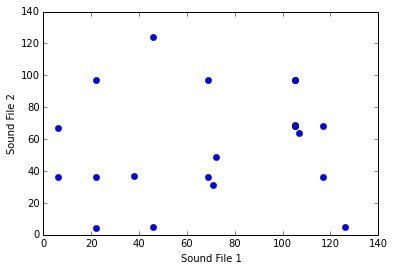

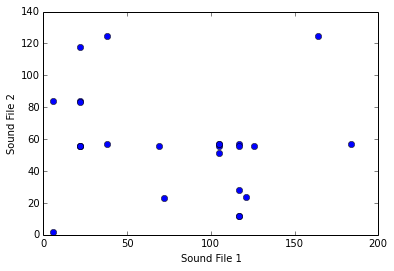

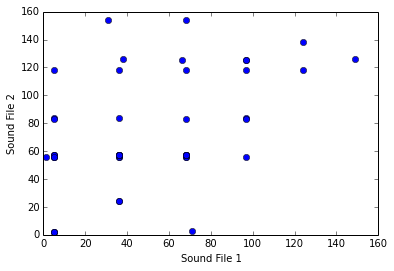

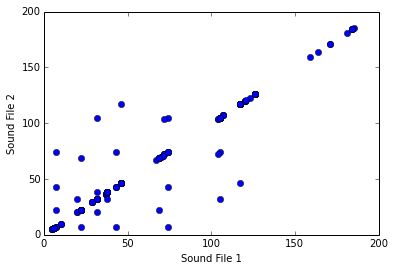

In [452]:
plot_times(time_pairs_1_2)
plot_times(time_pairs_1_3)
plot_times(time_pairs_2_3)
plot_times(time_pairs_dummy)